## Motivation & Kontext

Auf der Website https://offenedaten-konstanz.de/ der Stadt Konstanz stehen Wetterdaten zur Verfügung,
die ein interessantes Beispiel für den praktischen Umgang mit rohen
Sensordaten im kommunalen Kontext darstellen.

Ziel dieses Notebooks ist es,
- mich exemplarisch mit diesen Daten auseinanderzusetzen,
- mögliche Schritte zur Verbesserung der Datenqualität zu erproben,
- und Annahmen sowie Vorgehen transparent zu dokumentieren.

Das Notebook versteht sich als beispielhafte, dokumentierte Auseinandersetzung
mit den bereitgestellten Daten.




## Ziel des Skripts

Dieses Skript liest CSV-Wetterdaten, die über das Open-Data-Portal der
Stadt Konstanz (https://offenedaten-konstanz.de/) verfügbar sind, ein
und erprobt eine maskenbasierte Aufbereitung der Daten. Als Orientierung
dienen dabei öffentlich verfügbare Referenzdaten über die Open-Meteo-API.

In einem ersten Schritt wurden verschiedene statistische Ansätze
(z.B. gleitende Mediane) untersucht. Dabei zeigte sich, dass diese
Methoden bei stark verrauschten oder lückenhaften Messreihen nur
eingeschränkt aussagekräftig sind.

Aus diesem Grund wird im weiteren Verlauf ergänzend mit externen
Referenzdaten gearbeitet, um Auffälligkeiten besser einordnen zu können.



In [8]:
# Teile der API-Request-Logik basieren auf dem offiziellen Open-Meteo-Beispiel
# Weiterverarbeitung, Struktur und Anpassungen wurden vom Autor umgesetzt

import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import numpy as np
import matplotlib.pyplot as plt

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 47.6603,
	"longitude": 9.1758,
	"start_date": "2020-11-22",
	"end_date": "2021-03-21",
	"hourly": "temperature_2m",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m

reference_data = pd.DataFrame(data = hourly_data)
reference_data["date"]=pd.to_datetime(reference_data["date"])
reference_data = reference_data.set_index("date")
print("\nHourly data\n", reference_data)

Coordinates: 47.62741470336914°N 9.192750930786133°E
Elevation: 408.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                            temperature_2m
date                                     
2020-11-22 00:00:00+00:00            0.15
2020-11-22 01:00:00+00:00            0.80
2020-11-22 02:00:00+00:00           -0.10
2020-11-22 03:00:00+00:00           -0.10
2020-11-22 04:00:00+00:00           -0.50
...                                   ...
2021-03-21 19:00:00+00:00            1.75
2021-03-21 20:00:00+00:00            1.75
2021-03-21 21:00:00+00:00            1.65
2021-03-21 22:00:00+00:00            0.95
2021-03-21 23:00:00+00:00            0.85

[2880 rows x 1 columns]


In [9]:
# Einlesen der Wetterdaten mit Datumsindex
data = pd.read_csv(
    "./Downloads/Temperaturwerte_Rathaus_0_0.csv",
    sep=";",
    parse_dates=["date"],
    index_col="date"
).sort_index()


# Normalisierung der Temperaturwerte und Konvertierung in numerisches Format.
# Nicht eindeutig interpretierbare Einträge werden als NaN behandelt.
data["t"] = (
    data["t"].astype(str).str.strip()
    .str.extract(r"^(-?\d+(?:\.\d+)?)", expand=False)
    .pipe(pd.to_numeric, errors="coerce")
)

### Kurze Überprüfung grundlegender Datenmerkmale

Es erfolgt eine kurze Überprüfung beider Datensätze auf mögliche
doppelte Zeitstempel sowie auf fehlende Werte in den Referenzdaten.


In [10]:
print(f"Summe der doppelten Zeitstempeln in den csv-Rohdaten (data): {data.index.duplicated().sum()}\n")
print(f"Summe der doppelten Zeitstempel in den Referenzdaten (reference_data): {reference_data.index.duplicated().sum()}\n")
print(f"Fehlende Werte in den Referenzdaten: {reference_data["temperature_2m"].isna().sum()}")

Summe der doppelten Zeitstempeln in den csv-Rohdaten (data): 0

Summe der doppelten Zeitstempel in den Referenzdaten (reference_data): 0

Fehlende Werte in den Referenzdaten: 0


### Visualisierung der Rohdaten

Zu Beginn erfolgt eine einfache Visualisierung der Rohdaten.
Diese dient ausschließlich dazu, einen ersten Überblick über
Zeitverlauf, Datenlücken und auffällige Bereiche zu gewinnen und
unterstützt die Wahl geeigneter Aufbereitungsansätze.

Die Visualisierung liefert einen ersten Hinweis darauf, dass einzelne
Abweichungen auf Skalierungsunterschiede (z.B. verschobene Dezimalstellen)
zurückzuführen sein könnten. Auf dieser Basis wird im weiteren Verlauf
geprüft, ob entsprechende Annahmen zur Einordnung der Messwerte geeignet sind.


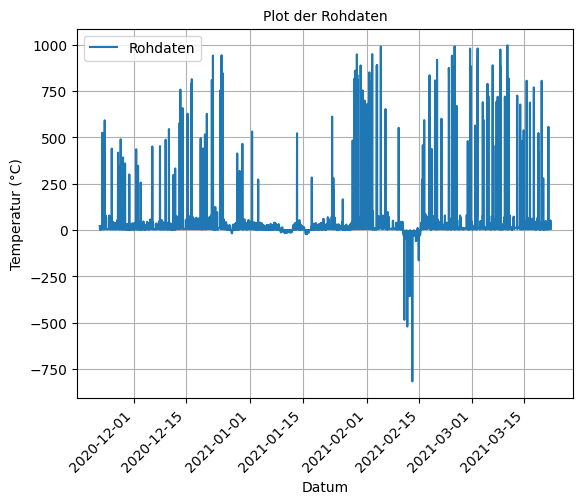

In [11]:
plt.plot(data.index, data["t"], label="Rohdaten")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Datum", fontsize=10)
plt.ylabel("Temperatur (°C)", fontsize=10)
plt.title("Plot der Rohdaten", fontsize=10)
plt.grid()
plt.show()

### Vorbereitung und Abgleich der Zeitreihen

Um einen zeitlich konsistenten Abgleich zu ermöglichen, werden die
Zeitindizes der beiden Datensätze auf eine gemeinsame Auflösung
vereinheitlicht. In diesem Fall erfolgt eine Rundung auf volle Stunden.

Anschließend werden die Messwerte mit den Referenzdaten zeitgleich
zusammengeführt. Auf Basis dieses Abgleichs wird die Differenz zwischen
den jeweiligen Temperaturwerten berechnet.

Als erster Filter wird eine Toleranz definiert, innerhalb derer die
Abweichung zwischen Messwert und Referenz als plausibel betrachtet
wird (±5 °C).


In [12]:
data.index = data.index.floor("h")
reference_data.index = reference_data.index.floor("h")

data = data.join(reference_data, how="inner")
data["difference"] = data["t"] - data["temperature_2m"]

first_filter = data["difference"].abs() < 5

### Vorgehensweise zur Aufbereitung der Messwerte

Für die weitere Verarbeitung werden zwei Arbeitskopien der Daten erzeugt:
- `dirty_data` enthält die ursprünglichen Messwerte,
- `clean_data` dient als schrittweise aufbereitete Datenbasis.

Ziel ist es, auffällige Messwerte in `clean_data` schrittweise zu
plausibilisieren, ohne die ursprünglichen Daten zu überschreiben.

Die Aufbereitung erfolgt in drei aufeinander aufbauenden Schritten:

1. **Skalierung um den Faktor 10**  
   Auffällige Messwerte werden durch 10 geteilt und mit den
   Referenzdaten verglichen. Liegt der so skalierte Wert innerhalb
   einer Abweichung von ±5 °C zur Referenz, wird er in `clean_data`
   übernommen.

2. **Skalierung um den Faktor 100**  
   Verbleibende auffällige Messwerte werden analog durch 100 geteilt
   und erneut mit den Referenzdaten abgeglichen. Werte innerhalb der
   ±5 °C-Toleranz werden entsprechend in `clean_data` ersetzt.

3. **Interpolation verbleibender Einzelwerte**  
   Nach den Skalierungsschritten treten verbleibende Auffälligkeiten
   nur noch vereinzelt auf. Diese Werte werden durch zeitliche
   Interpolation auf Basis der umliegenden Messpunkte geschätzt.


In [13]:
clean_data = data["t"].copy()
dirty_data = data.loc[~first_filter, ["t", "temperature_2m"]].copy()
ref = dirty_data["temperature_2m"]

cleaned_10 = dirty_data["t"] / 10
cleaned_100 = dirty_data["t"] / 100

mask_10_division = (cleaned_10 - ref).abs() < 5
mask_100_division = (cleaned_100 - ref).abs() < 5
only_100 = (~mask_10_division) & mask_100_division

clean_data.loc[dirty_data.index[mask_10_division]] = cleaned_10.loc[mask_10_division]
clean_data.loc[dirty_data.index[only_100]] = cleaned_100.loc[only_100]

still_dirty = (~first_filter) & (~mask_10_division.reindex(dirty_data.index, fill_value=False)) & (~mask_100_division.reindex(dirty_data.index, fill_value=False))
clean_data.loc[still_dirty] = np.nan

clean_filled = clean_data.interpolate(
    method="time",
    limit=3,              # max 3 Stunden am Stück füllen
    limit_direction="both"
)
clean_filled = clean_filled.rename("temperature").to_frame()

print("Noch dirty:", clean_filled.isna().sum())

Noch dirty: temperature    0
dtype: int64


### Vergleich vor und nach der Aufbereitung

Abschließend werden die ursprünglichen Messwerte den aufbereiteten
Daten gegenübergestellt. Die Visualisierung dient der transparenten
Darstellung der vorgenommenen Schritte und ihrer Auswirkungen auf
den Zeitverlauf.


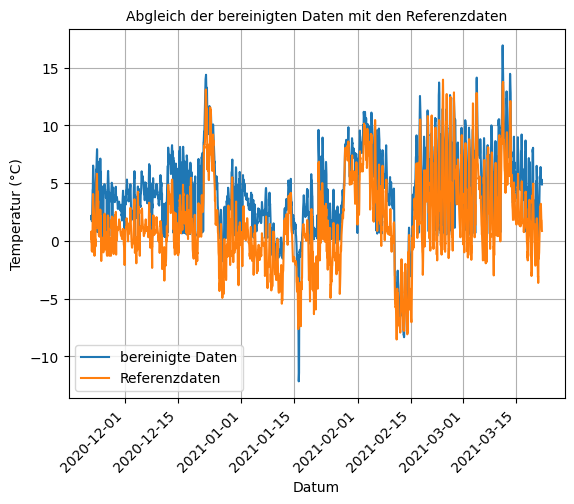

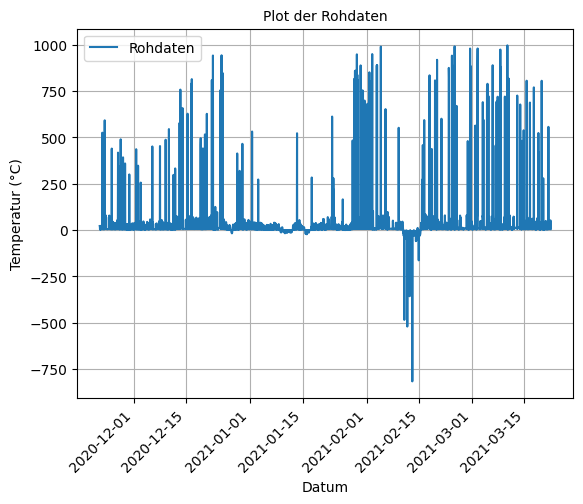

In [14]:
plt.plot(clean_filled.index, clean_filled["temperature"],label="bereinigte Daten")
plt.plot(data.index, data["temperature_2m"], label="Referenzdaten")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Datum", fontsize=10)
plt.ylabel("Temperatur (°C)", fontsize=10)
plt.title("Abgleich der bereinigten Daten mit den Referenzdaten", fontsize=10)
plt.grid()
plt.show()

plt.plot(data.index, data["t"], label="Rohdaten")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Datum", fontsize=10)
plt.ylabel("Temperatur (°C)", fontsize=10)
plt.title("Plot der Rohdaten", fontsize=10)
plt.grid()
plt.show()

### Ausblick

Das Notebook versteht sich als explorativer Prototyp und lässt sich
bei Bedarf in verschiedene Richtungen weiterentwickeln:

1. **Persistente Datenhaltung**  
   Die aufbereiteten Messwerte könnten in einer relationalen
   Datenbank (z.B. SQL) abgelegt werden. Das Vorgehen ließe sich
   dabei vermutlich auch auf die weiteren, ähnlich strukturierten CSV-Wetterdatensätze
   aus dem Offene-Daten-Portal anwenden.

2. **Automatisierter Abgleich mit Referenzdaten**  
   Falls künftig wieder eigene Temperaturmessungen erfolgen sollten,
   ließe sich das Skript erweitern, um regelmäßig aktuelle
   Referenzdaten von Open-Meteo abzurufen und neue Messwerte
   zeitnah einzuordnen.

3. **Zeitgesteuerte Verarbeitung**  
   Die regelmäßige Ausführung des Skripts könnte z.B. per cron oder airflow erfolgen. 

4. **Weiterführende Auswertungen**  
   Auf Basis konsistenter Zeitreihen wären grundlegende
   statistische Auswertungen (z.B. Min/Max/Mittelwerte) möglich.
